In [172]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from src.VAE import VAE
from src.early_stopping import EarlyStopping


In [173]:

path = '../../data/input/GTEx/GTEx_mini_random.gct'
gtex_df = pd.read_csv(path, skiprows=2, sep="\t")


In [174]:

# Drop zero columns
gtex_df = gtex_df.loc[:, (gtex_df != 0).any(axis=0)]

In [175]:
train_df, test_df = train_test_split(gtex_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [176]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

40464
4496
11240


In [177]:
# define hparams
hparams = {
    "dim": len(gtex_df.columns) - 2,
    "encoder_width": 128,
    "encoder_depth": 5,
    "emb_dim": 128,
    "decoder_width": 128,
    "decoder_depth": 6,
    "batch_norm": True,
    "Variational": False,
    
}
config = {
    "epochs": 50,
    "batch_size": 1024,
    "lr": 1e-3
}

device = "cpu"

In [178]:
class GTExDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.gene_ids = self.df['Name']
        # drop first 2 columns
        self.df.drop(self.df.columns[[0, 1]], axis=1, inplace=True)
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(self.df.to_numpy())
        self.df = pd.DataFrame(df_scaled)

    def get_gene_ids(self):
        return self.gene_ids
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        features = torch.tensor(self.df.iloc[idx], dtype=torch.float32)

        if self.transform:
            features = self.transform(features)

        return features, features # for Autoencoder

In [179]:
train_dataset = GTExDataset(train_df)
val_dataset = GTExDataset(val_df)
test_dataset = GTExDataset(test_df)
full_dataset = GTExDataset(gtex_df)
# Define DataLoader for each set
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
full_loader = DataLoader(full_dataset, batch_size=config['batch_size'], shuffle=True)

In [180]:
# Initialize model, loss function, and optimizer
model = VAE(hparams)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'])
train_loss_values = []
val_loss_values = []

# es = EarlyStopping()
# Training loop
for epoch in range(config['epochs']):
    train_epoch_losses= []
    val_epoch_losses=[]
    # Train step
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_epoch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    train_loss_values.append(np.mean(train_epoch_losses))
    print(f'Epoch [{epoch+1}/{config["epochs"]}], Train Loss: {np.mean(train_epoch_losses):.4f}')

    # Val step
    with torch.no_grad():
        for inputs, targets in train_loader:
            model.eval()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_epoch_losses.append(loss.item())
        val_loss_values.append(np.mean(val_epoch_losses))
        print(f'Validation Loss: {np.mean(val_epoch_losses):.4f}')
    

Epoch [1/50], Train Loss: 1.1435
Validation Loss: 1.1514
Epoch [2/50], Train Loss: 1.1107
Validation Loss: 1.0557
Epoch [3/50], Train Loss: 1.0546
Validation Loss: 1.0135
Epoch [4/50], Train Loss: 1.0018
Validation Loss: 0.9903
Epoch [5/50], Train Loss: 0.9884
Validation Loss: 0.9823
Epoch [6/50], Train Loss: 0.9693
Validation Loss: 0.9551
Epoch [7/50], Train Loss: 0.9486
Validation Loss: 0.9390
Epoch [8/50], Train Loss: 0.9314
Validation Loss: 0.9197
Epoch [9/50], Train Loss: 0.9146
Validation Loss: 0.8988
Epoch [10/50], Train Loss: 0.8903
Validation Loss: 0.8908
Epoch [11/50], Train Loss: 0.8658
Validation Loss: 0.8560
Epoch [12/50], Train Loss: 0.8459
Validation Loss: 0.8273
Epoch [13/50], Train Loss: 0.8187
Validation Loss: 0.8079
Epoch [14/50], Train Loss: 0.7956
Validation Loss: 0.7793


KeyboardInterrupt: 

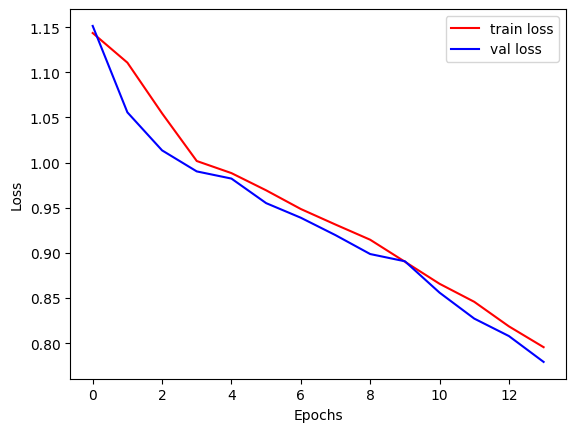

In [181]:
with torch.no_grad():
    plt.plot(np.array(train_loss_values), 'r', label='train loss')
    plt.plot(np.array(val_loss_values), 'b', label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [182]:
embeddings = []
# Extract embeddings
with torch.no_grad():
    model.eval()
    for inputs, _ in full_loader:
        x = model.encoder(inputs)
        embeddings.append(x)
embeddings = torch.vstack(embeddings)
len(embeddings)

56200

In [183]:

emb_df = pd.DataFrame(
    data = embeddings,
    index = full_dataset.get_gene_ids(),
    columns = [f'EMB_{i}' for i in range(encoding_size)]
)
emb_df.index.name = "gene_id"
emb_df

ValueError: Shape of passed values is (56200, 128), indices imply (56200, 512)

In [169]:
emb_df.index = emb_df.index.str.split('.').str[0]
emb_df

,EMB_0,EMB_1,EMB_2,EMB_3,EMB_4,EMB_5,EMB_6,EMB_7,EMB_8,EMB_9,...,EMB_502,EMB_503,EMB_504,EMB_505,EMB_506,EMB_507,EMB_508,EMB_509,EMB_510,EMB_511
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,1.127837,0.676289,0.786240,1.278119,0.0,0.0,0.845309,0.0,0.696969,0.199997,...,0.611392,0.944856,0.0,0.0,0.0,0.846675,0.743735,0.0,0.955779,0.0
ENSG00000227232,1.291149,0.784297,0.907080,1.463062,0.0,0.0,0.964473,0.0,0.804464,0.225191,...,0.701315,1.092141,0.0,0.0,0.0,0.987400,0.857030,0.0,1.089680,0.0
ENSG00000278267,1.178725,0.715396,0.830694,1.337535,0.0,0.0,0.874631,0.0,0.728439,0.207541,...,0.644156,0.990084,0.0,0.0,0.0,0.904812,0.783480,0.0,0.992650,0.0
ENSG00000243485,1.291969,0.786009,0.906195,1.465148,0.0,0.0,0.965583,0.0,0.804706,0.225714,...,0.702277,1.091530,0.0,0.0,0.0,0.989218,0.859459,0.0,1.090493,0.0
ENSG00000237613,1.297306,0.788813,0.911626,1.471270,0.0,0.0,0.969942,0.0,0.808769,0.226654,...,0.705291,1.097547,0.0,0.0,0.0,0.992373,0.861424,0.0,1.095219,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695,1.289318,0.783705,0.905587,1.461493,0.0,0.0,0.963399,0.0,0.802997,0.225883,...,0.700298,1.090275,0.0,0.0,0.0,0.985517,0.856353,0.0,1.088006,0.0
ENSG00000210194,1.295609,0.787590,0.910318,1.469142,0.0,0.0,0.968818,0.0,0.807618,0.226527,...,0.704385,1.095806,0.0,0.0,0.0,0.990979,0.860254,0.0,1.093475,0.0
ENSG00000198727,1.279792,0.778227,0.897837,1.450630,0.0,0.0,0.956305,0.0,0.797687,0.223166,...,0.695449,1.080841,0.0,0.0,0.0,0.978646,0.850502,0.0,1.079980,0.0


In [170]:
emb_df.to_csv(f"../../data/embeddings/GTEx_AE_embeddings.tsv", sep="\t")